# Sentiment Trader
James Chan 2018

## Overview
A popular approach traders take to beat the stock market is by analyzing the market sentiment.  This is common done by analzying stock market news pertaining to a particular stock, a certain the sector, or even the world economy as a whole.  

#### Examples
* News headlined "Elon Musk pushed off Model 3 production once again!!!" could mean a sell/short opportunity for Tesla.
* News headlined "Pfizer found definitive cure for cancer!" could mean a long opportunity for Pfizer, for the pharmaceutical sector, or even for the world economy altogether.

#### Machine Learning and NLP
Machine Learning is rapidly gaining grounds in quantitative finance due to its phenomonenal performance in forecasting, optimization, and decision-making. By combining the predictive power of machine learning with the processing of textual data in news, a intelligent agent may be devised which can translate news into trades with remarkable performance.

In this exercise we employ the following steps to construct a sentiment trader agent to trade Tesla.  More details of these steps are discussed later.
1. Acquire historical news and price data of Tesla from the web
2. Clean the news and translate text into one hot vectors using NLP techniques
3. Train logistics regression classifer using the return of next day as label
4. Assess the performance of the trader in-sample and out-of-sample

#### Table of Content
1. Framing the Problem
2. Process News Data with NLP
3. Prepare Data for Supervised Learning
4. Train the Logistics Regression (Classifer)
5. Back Test
6. Conclusion

#### Technology Stack
<img src="img/techstack.png"/>

In [1]:
'''
Sentiment Trader
James Chan 2018
'''
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import st_utils as sut
import trader_utils as tut
import string

from scipy.stats import mode

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from dateutil import parser
from datetime import timedelta, date

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
# initialize date range of interest.  Longer would be even better, but I would need to sign up for a paid plan at newsapi.org
start_date = '2018-01-01'
end_date = '2018-8-31'

In [3]:
# request news from newsapi.org
keywords = ['tesla'] #use tesla as keyword
news_source = 'wsj.com, bloomberg.com, cnbc.com' #use these 3 news outlet. More can be even better
df = sut.get_news(keywords, start_date, end_date, news_source)
df.to_csv('news_dataset.csv')

{'status': 'ok', 'totalResults': 1917, 'articles': []}
total number of articles  1917
downloading page:  1
downloading page:  2
downloading page:  3
downloading page:  4
downloading page:  5
downloading page:  6
downloading page:  7
downloading page:  8
downloading page:  9
downloading page:  10
downloading page:  11
downloading page:  12
downloading page:  13
downloading page:  14
downloading page:  15
downloading page:  16
downloading page:  17
downloading page:  18
downloading page:  19
downloading page:  20
download complete


In [4]:
#read news data into dataframe and print it out for sanity check 
df_news = pd.read_csv('news_dataset.csv', index_col=0, encoding="ISO-8859-1")
df_news.head()

,Published,Title,Body,Keyword,Source
0,2018-04-03T13:05:17Z,"Tesla Ends 1Q Making 2,020 Model 3 Sedans per ...","Tesla 1Q deliveries totaled 29,980 vehicles, B...",tesla,Bloomberg
1,2018-07-24T07:48:09Z,Tesla Wants Its Money Back,Elon Musk is asking for donations to save Tesl...,tesla,The Wall Street Journal
2,2018-07-01T22:13:00Z,What Tesla can do to keep the bears at bay dur...,"Buckle up, because Tesla could be in for a bum...",tesla,CNBC
3,2018-05-09T15:00:00Z,Two Florida teenagers killed in Tesla crash,Tesla said it is cooperating with authorities ...,tesla,CNBC
4,2018-05-10T19:00:00Z,NHTSA joins NTSB in looking into fatal Tesla c...,Tesla said it is cooperating with authorities ...,tesla,CNBC


The news is now in the form of a dataframe.  Further processing/cleaning will be needed before it can be fed into our agent.  But before we do that, let's get the daily return first so we have all the raw data necessary for this exercise

In [5]:
# get Tesla historical price from csv file, which was downloaded previously from yahoo and made locally accessible.
dates = pd.date_range(start_date, end_date)
file = 'TSLA.csv'
df_stock = sut.get_data(file, dates)

In [6]:
# calculate daily return of Tesla
df_stock['Return'] = df_stock['Adj Close'].shift(-1)/df_stock['Adj Close'].values-1.0
df_stock.drop(df_stock.index[-1], inplace=True)

In [7]:
#print dataframe for sanity check
df_stock.head()

,Adj Close,Return
2018-01-02,320.529999,-0.010233
2018-01-03,317.250000,-0.008290
2018-01-04,314.619995,0.006230
2018-01-05,316.579987,0.062638
2018-01-08,336.410004,-0.008085


Now that we have both the news and the daily return, it's time to discuss the framing of the problem

## 1. Framing the Problem
In the real world, speed plays a critcal factor in the success of a trading firm.  Ideally bots are used to monitor news outlets real-time so news can be quickly fed into the trading system pipeline as they are published.  If a news is deemed positive by the trading agent, a buy signal is generated.  Likewise, a sell signal will be generated if the news is deemed negative in nature.  

Evidently, the speed of the data pipeline and the thriftness of execution is critical. Otherwise there is no point automating the trading system since humans can analyze the news sentiment very accurately (but slowly).  

### Sentiment as a Supervised Learning Problem
<img src="img/framing1-training.png"/>
<center>Figure 1. Labeling</center> 
* News released in red region are labeled as negative (0) because stock slipped in that region
* News released in green region are labeled as positive (1) because stock rose in that region

Once we have the data labeled, we can train any supervised model using news as input features. I have chosen logistics regression just because I might scale this to a deep learning problem later and logistics regression is really just a single layer neural network.  

Now, notice the news published at 12:05pm in Figure 1 actually is a good news labeled as a bad news.  This is essentially the noise of the problem and also a by-production of simplifying the problem.  What can we do about it?  Nothing, we let our learner take care of the noise and acknowledge the possibility this type of counter-intuitive movement in real life.

Another interesting point to take notice is that the stock price have already began to move BEFORE news are released.  Again, in this simplistic representation, we group all news and price movement into daily intervals.  It is less than ideal, but we want to just capture the overall sentiment of the day.  What is not shown here is the news released during market close.  The conscious decision here is to take any news released after close and group them into the same set of news released during market open the following day. 

### Sentiment Trader Real-time
<img src="img/framing2-testing.png"/>
<center>Figure 2. Live Testing Mechanics</center> 

During test time, we feed news into our sentiment trader as they are published.  Figure 2 is a simplistic version of this process.  In reality it will not make sense to place order before news are released.  Here, we are simulating as if we get to place orders instantaneously after we read in a news or a batch of news.  

What is nice about training a sentiment trading agent using logistics regression is we are essentially training the weights of each word and it's our choice what kind of time period we want to apply towards trading.  

#### NOTE: News presented in Figure 1 and 2 are ficitional for demonstration purposes

## 2. Process News Data with NLP

In [8]:
# map published time to close date.
def map_to_close_date(published_date):
    dt = parser.parse(published_date[:-1]) #-1 to ignore the Z, which is GMT.
    dt = dt - timedelta(hours=20) #shift back by 20 hrs.
    return pd.Timestamp(year=dt.year, month=dt.month, day=dt.day)

In [9]:
# map news to close date
df_news['Published'] = df_news['Published'].apply(map_to_close_date)

In [10]:
# combine title and body into single text
df_news['Text'] = df_news['Title'] + ' ' + df_news['Body']

In [11]:
# just keep published and the combined text
df_news = df_news[['Published','Text']]

In [12]:
# merge news and stock
df_stock['Published'] = df_stock.index
df_merged = pd.merge(df_news, df_stock, how='left', on='Published')
df_merged = df_merged.dropna()
df_merged = df_merged.sort_values(by='Published')
df_merged.head()

,Published,Text,Adj Close,Return
1407,2018-01-02,Stock Fund That Beats 95% of Peers Ignores CEO...,320.529999,-0.010233
1737,2018-01-02,Five Things You Need to Know to Start Your Day...,320.529999,-0.010233
1726,2018-01-02,Car Sales to Top 90 Million Globally for First...,320.529999,-0.010233
1398,2018-01-02,Electric Car Drivers Are Too Smart to Own Elec...,320.529999,-0.010233
410,2018-01-02,"With one simple tweet, Elon Musk shows a maste...",320.529999,-0.010233


We don't end up using date as index because each news has a date associated with it so there are mulitple dates.  This will be further handled later.  For now, we see that we have associated each news with a return per Figure 1. 

Next we will be processing the text into format that can be accepted by a supervised learner. Keep in mind that in the succeeding NLP approach we are ignoring the time-series aspect of a sentence.  For example, we strip stop words like "is" or "the", which can have meaning in a sequence model such as Recurrent Neural Network (That's a project for another day)

In [13]:
def tokenize_news(text):
    if(type(text)==float):
        return []
    lmtzr = WordNetLemmatizer() #lemmatize basically turns word into it's base form (e.g. Children -> child)
    stmr = PorterStemmer() #stemmer is similiar to lemmatize except it's more brute force, I will not attempt to explain here.
    translator = str.maketrans('', '', string.punctuation) #get rid of punctuations as they are more distracting than helpful
    text = (text.translate(translator)) 
    text = "".join(c for c in text if ord(c)<128) #strip if not ascii characters
    tokens = word_tokenize(text) #tokenize basically discretize a sentence into words.
    t = []
    minlen =  4 #strip short words
    maxlen = 20 #strip long words
    for token in tokens:
        #get rid of non-numeric words and stop words.  Stop words are words with little meaning like "is" or "the"
        if len(token) < minlen or len(token) > maxlen or token.isnumeric() or token in stopwords.words('english'):
            pass
        else:
            token = lmtzr.lemmatize(token)
            token = stmr.stem(token)
            t.append(token)
    return t

In [14]:
df_merged['Text'] = df_merged['Text'].apply(tokenize_news)

In [15]:
df_merged.head()

,Published,Text,Adj Close,Return
1407,2018-01-02,"[stock, fund, that, beat, peer, ignor, talk, r...",320.529999,-0.010233
1737,2018-01-02,"[five, thing, need, know, start, your, caught,...",320.529999,-0.010233
1726,2018-01-02,"[sale, million, global, first, time, global, s...",320.529999,-0.010233
1398,2018-01-02,"[electr, driver, smart, electr, car, almost, p...",320.529999,-0.010233
410,2018-01-02,"[with, simpl, tweet, elon, musk, show, master,...",320.529999,-0.010233


Looks pretty good, we have been able to tokenize our news into meaningful, discrete words.  

## 3. Prepare Data for Supervised Learning

In [16]:
#construct vocabulary and frequency.  frequency is not really needed, just nice to have for understanding the concept.
vocab = {}
frequency = {}
ignore = ['bloomberg', 'journal']
index = 0
for title in df_merged['Text']:
    for word in title:
        if word in ignore:
            continue
        if word not in vocab:
            
            vocab[word] = index
            index += 1
            frequency[word] = 1
        else:
            frequency[word] += 1

In [17]:
#visualize words frequency
for i, freq in enumerate(sorted(frequency.items(), key=lambda x:x[1], reverse=True)):
    if i == 10:
        break
    print(freq)

('tesla', 1092)
('musk', 458)
('elon', 364)
('compani', 254)
('stock', 246)
('model', 240)
('say', 182)
('market', 159)
('electr', 159)
('share', 158)


Here we manually inspect words and their frequencies.  No suprised that news about Tesla has Tesla mentioned the most number of times.  Obivously Elon Musk is oftenly mentioned.  Interesting to see that China is often featured in Tesla news. The result of this cell could change if more news is acquired.

In [18]:
vocab_len = len(vocab)
vocab_len

4522

The number above is the number of words within the news we processed.  This will be the dimension of our text vector, which is the preferred format for a supervised learner.  Essentially a text vector is a one hot vector with each position mapped to a word.

In [19]:
#train test split.
in_sd = df_merged['Published'].iloc[0]
in_ed = pd.datetime(2018,4,30)
out_sd = pd.datetime(2018,5,1)
out_ed = df_merged['Published'].iloc[-1]

df_training_data = df_merged[np.logical_and(df_merged['Published'] >= in_sd, df_merged['Published'] <= in_ed)]
df_testing_data = df_merged[np.logical_and(df_merged['Published'] >= out_sd, df_merged['Published'] <= out_ed)]

In [20]:
#this function will turn text into one hot vector
def to_one_hot(text):
    #return one hot vector of shape (vocab_len, 1)
    array = np.zeros((vocab_len, 1))
    for word in text:
        if word in vocab:
            index = vocab[word]
            array[index] = 1
    return array

In [21]:
#further process dataframe into ndarray
def get_X(df_text):
    X = np.empty((vocab_len,0))
    for text in df_text:
        array = to_one_hot(text)
        X = np.hstack((X,array))
    X = X.T
    return X

In [22]:
# here is the exciting part. here we are going to create the training data!
train_x = get_X(df_training_data['Text'])
test_x = get_X(df_testing_data['Text'])

In [23]:
# get labels
train_y = df_training_data['Return'].values.copy()
test_y = df_testing_data['Return'].values.copy()

In [24]:
train_y[train_y <= 0] = 0
train_y[train_y > 0] = 1

test_y[test_y <= 0] = 0
test_y[test_y > 0] = 1

In [25]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(671, 4522)
(671,)
(555, 4522)
(555,)


This really isn't a whole lot of data.  newsapi.org is already generous enough to provide this much of free data.  One thing I can do is to change the problem scenario to the entire sector, this way I can grab news from hundreds of companies, and have a lot more training data this way.  However, for this exercise we focus on Tesla and those news about Tesla are usually presented in some similiar fashion (i.e., "Elon Musk did XYZ")

## 4. Train the Logistics Regression (Classifer)

In [26]:
#train the model
model = Sequential()
model.add(Dense(1, input_dim=train_x.shape[1], activation='relu', kernel_initializer='uniform'))
# unsupress below if we want to go deeper
# model.add(Dense(12, activation='relu', kernel_initializer='uniform'))
# model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)

In [27]:
#view weights
weights, biases = model.layers[0].get_weights()
for i, k in enumerate(vocab.keys()):
    if i == 10:
        break
    print(k, weights[i])

stock [0.01752777]
fund [0.10849897]
that [0.03060291]
beat [0.00215029]
peer [-0.01190196]
ignor [-0.23391761]
talk [-0.01170337]
research [-0.01124556]
read [-0.01700739]
brokerag [-0.252196]


Hopefully we see that those words with positive connotation tend to have positive weights and opposite for negative words. This is not always the case when our training data is small and because our assumption of the problem is inherently proned to noise.

In [28]:
#assess in-sample accuracy
predictions = model.predict_classes(train_x)
predictions = predictions.reshape((predictions.shape[0],))
np.sum(predictions == train_y) / train_y.shape[0]

0.9388971684053651

In [29]:
#assess out-of-sample accuracy
predictions = model.predict_classes(test_x)
predictions = predictions.reshape((predictions.shape[0],))
np.sum(predictions == test_y) / test_y.shape[0]

0.5225225225225225

## 5. Back Test

In [30]:
#generate trades
def generate_trades(df, ticker):
    sd = df['Published'].iloc[0]
    ed = df['Published'].iloc[-1]
    trades = tut.get_prices(ticker, sd, ed)
    trades[:] = 0
    curr_date = sd
    votes = []
    for date, text in zip(df['Published'], df['Text']):
        if date != curr_date:
            trades.loc[curr_date] = mode(votes)[0][0]
            votes = []
            curr_date = date
        text_vector = to_one_hot(text)
        prediction = model.predict_classes(text_vector.T)
        votes.append(prediction[0][0])
    trades = tut.predictions_to_trades(ticker, trades.values, sd, ed, 1, 0)
    return trades

In [31]:
in_trades = generate_trades(df_training_data, 'TSLA')

In [32]:
starting_cash = 100000
holding_limit = 1000
btr = tut.BackTester(starting_cash, holding_limit)

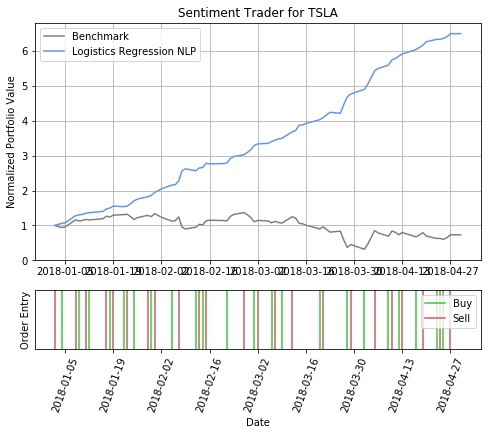

In [33]:
btr.backtest(in_trades, 'Sentiment Trader for TSLA', 'Logistics Regression NLP')

In-sample result looks great, and perhaps too great which in cases can be prone to overfitting.  For the purpose of the exercise, we can see that we are able to map a given news into trading signals Buy and Sell correctly.

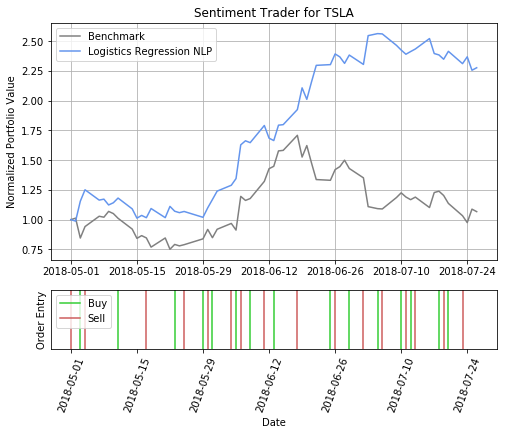

In [34]:
out_trades = generate_trades(df_testing_data, 'TSLA')
btr.backtest(out_trades, 'Sentiment Trader for TSLA', 'Logistics Regression NLP')

Out-of-sample result also looks great, which may have some merit, but more data and experiment will be performed in order to validate the integrity of the results.  I am confident that with a larger data set (> ~100000 news entries), a definitive pattern may be discovered.   

## 6. Conclusion
This is a great exercise that combines NLP and Machine Learning to tackle the domain of stock trading.  There are a lot of assumptions and simplification that go into this problem. This excercise is more educational in nature which demonstrate the flexibility and strength of machine learning algorithms along with some common NLP techniques in practice. That's it for now, cheers.